# Dynamic Matrix Control

## Question

Consider following process with transfer function $G_p(s)$:

$$
g_p(s)=\frac
{0.5848(-0.3549s+1)}
{0.1828s^2+0.8627s+1}
$$

plot response using DMC with parameters:

|$\Delta t$|N|P|M|
|---|---|---|---|
|0.1|50|25|1|
|0.1|50|10|1|
|0.1|50| 8|1|
|0.1|50| 7|1|

In [1]:
#import packages
import numpy as np;
import control;
import matplotlib.pyplot as plt;

## 1 Finite Step Response

In [2]:
num=0.5849*np.array([-0.3549,1.0])
den=[0.1828,0.8627,1.0]
Gp=control.tf(num,den)
print(Gp)


   -0.2076 s + 0.5849
-------------------------
0.1828 s^2 + 0.8627 s + 1



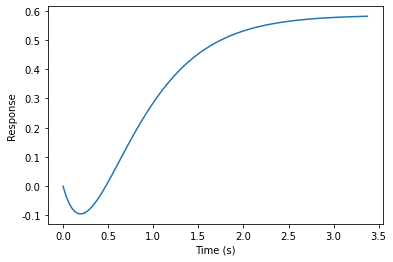

In [3]:
(T,yout)=control.step_response(Gp)
plt.plot(T,yout)
plt.xlabel("Time (s)")
plt.ylabel("Response")
plt.show()

## Dynamic Matrix Control

In [5]:
delta_t_list=[0.1,0.1,0.1,0.1]
N_list=[50,50,50,50]
P_list=[25,10,8,7]
M_list=[1,1,1,1]
for i in range(0,4):
    delta_t=delta_t_list[i]
    N=N_list[i]
    P=P_list[i]
    M=M_list[i]
    #TODO

0 25
1 10
2 8
3 7


## References

- Siang Lim.February 2020.[Implementing Dynamic Matrix Control in Python](https://github.com/csianglim/DMC/blob/master/DMC.ipynb)